(374, 380)


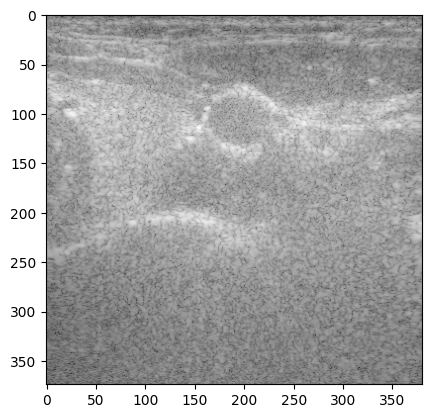

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
Idata = np.load('/home/mhb0917/의료영상처리/202255646/artery3_IData_bmode.npy')
Qdata = np.load('/home/mhb0917/의료영상처리/202255646/artery3_QData_bmode.npy')
IQdata = Idata + 1j * Qdata
shape = IQdata.shape
print(shape)
IQdata = abs(IQdata)
img_log = np.log1p(IQdata) 
plt.imshow(img_log, cmap='gray')


In [44]:
import numpy as np
import matplotlib.pyplot as plt

i_data = np.load('/home/mhb0917/의료영상처리/202255646/artery3_IData_doppler.npy')
q_data = np.load('/home/mhb0917/의료영상처리/202255646/artery3_QData_doppler.npy')
iq_data = i_data + 1j * q_data
#iq_data = abs(iq_data)
shape = iq_data.shape
print(shape)

#plt.imshow(iq_data[:,:,100], cmap='gray')

(180, 95, 300)


In [45]:
# Cell 3: SVD를 위해 2D로 변환
depth, lateral, ensemble = iq_data.shape
iq_2d = iq_data.reshape(depth * lateral, ensemble)  # shape: (17100, 300)
#plt.imshow(iq_2d, cmap='gray')

(17100, 300) (300,) (300, 300)


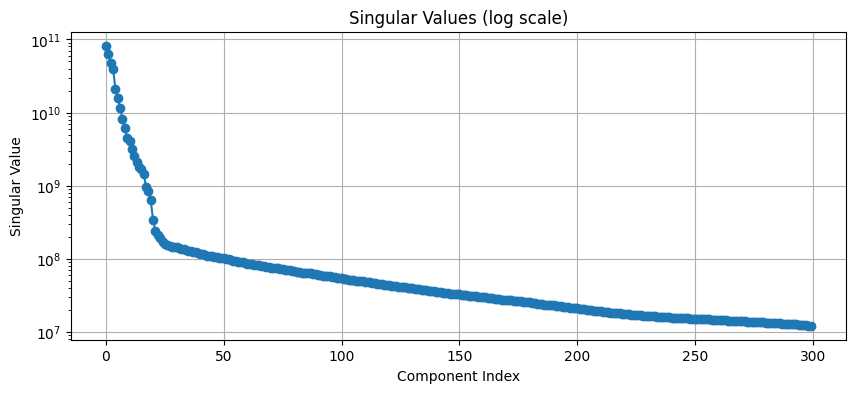

In [46]:
from numpy.linalg import svd  # numpy 내부 모듈

U, S, Vh = svd(iq_2d, full_matrices=False)
print(U.shape, S.shape, Vh.shape)  # U: (17100, 300), S: (300,), Vh: (300, 300)
#print(S)  # singular values

# 특이값 시각화
plt.figure(figsize=(10,4))
plt.plot(S, marker='o')
plt.yscale('log')  # 로그 스케일
plt.title("Singular Values (log scale)")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()

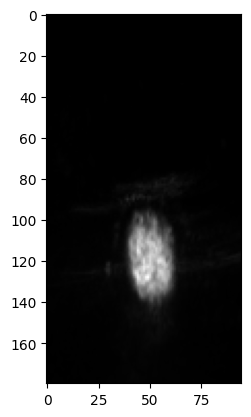

In [47]:
# 중간 성분만 유지
k1, k2 = 30, 100
S_filtered = np.zeros_like(S)
S_filtered[k1:k2] = S[k1:k2]
Sigma = np.diag(S_filtered)

# 필터링된 영상 복원
A_filtered = U @ Sigma @ Vh

# 복원된 A_filtered을 다시 reshape 해서 영상화
power_doppler_filtered = np.mean(np.abs(A_filtered)**2, axis=1)  
plt.imshow(power_doppler_filtered.reshape(180, 95), cmap='gray')

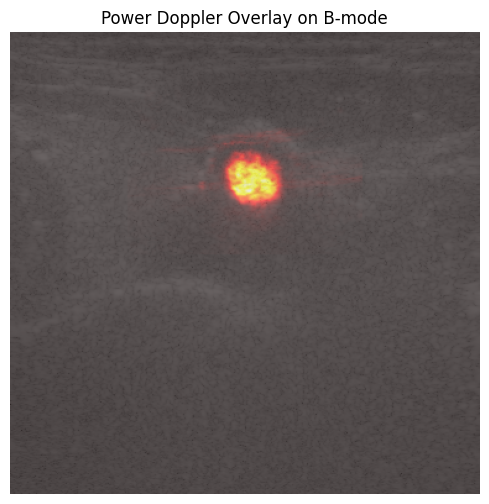

In [48]:
import matplotlib.cm as cm

bmode_rgb = np.stack([img_log]*3, axis=-1)
bmode_rgb = bmode_rgb / np.max(bmode_rgb)
doppler_img = power_doppler_filtered.reshape(depth, lateral)
# 4. Doppler 해상도 보정 (x축 0.2mm → 0.1mm로 보간: 2배 확대)
scale_x = 0.2 / 0.1
doppler_resized = cv2.resize(doppler_img, (int(lateral * scale_x), depth))  # shape: (180, 190)
# 5. 중심 정렬 (Doppler: (0, 47.5) → B-mode: (0, 190))
bmode_h, bmode_w = bmode_rgb.shape[:2]
doppler_h, doppler_w = doppler_resized.shape[:2]
dx = int(190 - 47.5 * scale_x)  # lateral offset

# 6. 도플러 패딩 삽입 (B-mode 크기에 맞춰 위치 맞추기)
doppler_padded = np.zeros((bmode_h, bmode_w))
doppler_padded[0:doppler_h, dx:dx + doppler_w] = doppler_resized / np.max(doppler_resized)

# 7. hot color map + alpha 블렌딩
doppler_colored = cm.hot(doppler_padded)[..., :3]
alpha = 0.6
overlay = (1 - alpha) * bmode_rgb + alpha * doppler_colored
overlay = np.clip(overlay, 0, 1)

# 8. 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title("Power Doppler Overlay on B-mode")
plt.axis('off')
plt.show()

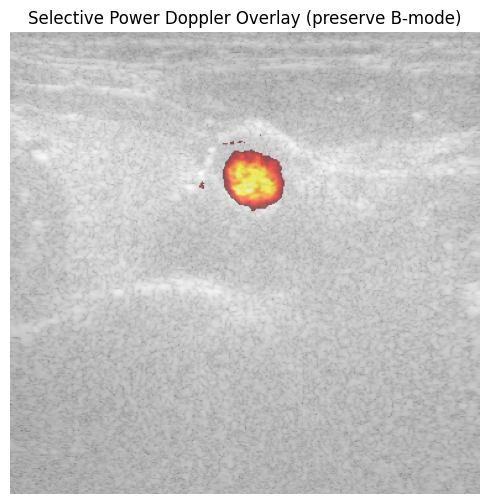

In [49]:
import matplotlib.cm as cm

# 1. B-mode RGB로 변환 및 정규화
bmode_rgb = np.stack([img_log] * 3, axis=-1)
bmode_rgb = bmode_rgb / np.max(bmode_rgb)

# 2. Doppler 영상 reshape 및 해상도 보정
doppler_img = power_doppler_filtered.reshape(depth, lateral)
scale_x = 0.2 / 0.1  # 2배 확대
doppler_resized = cv2.resize(doppler_img, (int(lateral * scale_x), depth))  # (180, 190)

# 3. 중심 정렬
bmode_h, bmode_w = bmode_rgb.shape[:2]
doppler_h, doppler_w = doppler_resized.shape[:2]
dx = int(190 - 47.5 * scale_x)

# 4. Doppler 정규화 및 padding
doppler_norm = doppler_resized / np.max(doppler_resized)
doppler_padded = np.zeros((bmode_h, bmode_w))
doppler_padded[0:doppler_h, dx:dx + doppler_w] = doppler_norm

# 5. hot colormap 적용
doppler_colored = cm.hot(doppler_padded)[..., :3]

# 6. 의미 있는 도플러 영역만 마스킹 (threshold 이상만 오버레이)
threshold = 0.1
mask = doppler_padded > threshold
mask = np.stack([mask] * 3, axis=-1)  # RGB 마스크

# 7. alpha blending (선택적 오버레이)
alpha = 0.6
overlay = np.where(mask,
                   (1 - alpha) * bmode_rgb + alpha * doppler_colored,
                   bmode_rgb)
overlay = np.clip(overlay, 0, 1)

# 8. 결과 출력
plt.figure(figsize=(10, 6))
plt.imshow(overlay)
plt.title("Selective Power Doppler Overlay (preserve B-mode)")
plt.axis('off')
plt.show()
